In [1]:
import pwd
from IPython import get_ipython

get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

/tmp/ipykernel_7213/2117665699.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_7213/2117665699.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


In [2]:
import functools
from typing import Any, Callable, Sequence, Optional

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state
import jax
from jax import lax, random, numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from Datasets import Spiral

In [4]:
seed = 23
key = random.PRNGKey(seed)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
key, ds_key = random.split(key)
spiral = Spiral(100, ds_key)
dataset = spiral.get_dataset()


def make_batches(key, dataset, batch_size=64):
    """This method returns a list containing batches sampled randomly from the
    dataset, with the indicated batch size (except for the last batch, which
    might be smaller"""

    
    n_points = dataset.shape[0]
    remainder = n_points % batch_size
    num_full_batches = (n_points - remainder)/batch_size
    permuted_dataset = random.permutation(key, dataset)
    batches_list = []
    for batch in range(int(num_full_batches)):
        batches_list.append(permuted_dataset[batch:batch+batch_size, :])
    batches_list.append(permuted_dataset[-remainder-1:-1, :])
    return batches_list


In [5]:
class FCNN(nn.Module):
    num_neurons_per_layer: Sequence[int]  # data field (nn.Module is Python's dataclass)

    def setup(self):  # because dataclass is implicitly using the  __init__ function... :')
        self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

    def __call__(self, x):
        activation = x
        for i, layer in enumerate(self.layers):
            activation = layer(activation)
            if i != len(self.layers) - 1:
                activation = nn.relu(activation)
        return jnp.exp(nn.log_softmax(activation))

model = FCNN(num_neurons_per_layer=[10, 10, 10, 10, 10, 2])
key, init_x_key = random.split(key)
x_init = random.uniform(init_x_key, (2,))
key, init_key = random.split(key)
params = model.init(init_key, x_init)


In [6]:
def make_loss_fn(model, data, labels):
    def loss_fn(params):
        preds = model.apply(params, data)
        one_hot_gt_labels = jax.nn.one_hot(labels, num_classes=2)
        loss = -jnp.mean(jnp.sum(one_hot_gt_labels * jnp.log(preds), axis=-1))
        return loss   
    return loss_fn

In [7]:
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)

In [8]:
epochs = 100

for epoch in range(epochs):
    key, batch_key = random.split(key)
    batches = make_batches(batch_key, dataset)
    epoch_loss = jnp.empty((len(batches),))
    for batch_nb, batch in enumerate(batches):
        batch_data = batch[:, 1:]
        batch_labels = jnp.squeeze(batch[:, :1], axis=1)
        loss = make_loss_fn(model, batch_data, batch_labels)
        loss, grads = jax.value_and_grad(loss)(params)
        epoch_loss = epoch_loss.at[batch_nb].set(loss)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
    if epoch % 5 == 0:
        #print(jnp.mean(epoch_loss))
        print(f'epoch {epoch}, loss = {loss}')
    

epoch 0, loss = 0.5326905846595764
epoch 5, loss = 0.6580111980438232
epoch 10, loss = 0.3812183737754822
epoch 15, loss = 0.74518883228302
epoch 20, loss = 0.6235586404800415
epoch 25, loss = 0.6066799163818359
epoch 30, loss = 0.47047436237335205
epoch 35, loss = 0.3595156669616699
epoch 40, loss = 0.2851572632789612
epoch 45, loss = 0.322348415851593
epoch 50, loss = 0.2003539353609085
epoch 55, loss = 0.0691700428724289
epoch 60, loss = 0.34491032361984253
epoch 65, loss = 0.13873149454593658
epoch 70, loss = 0.02005581744015217
epoch 75, loss = 0.0061842105351388454
epoch 80, loss = 0.023143533617258072
epoch 85, loss = 0.008338739164173603
epoch 90, loss = 0.03958133980631828
epoch 95, loss = 0.04392950236797333


In [17]:
def plot_decision_boundary(ax, x_min=-10., x_max=10., y_min=-10., y_max=10.):
    """This function allows to plot the network's decision boundary on a given figure.

    Args:
    ax (matplotlib.axes.Axes): the pyplot figure on which the dataset is plotted.
    x_min (float, optional): lower bound of the x axis of the plot. Defaults to -10..
    x_max (float, optional): high bound of the x axis of the plot. Defaults to 10..
    y_min (float, optional): lower bound of the y axis of the plot. Defaults to -10..
    y_max (float, optional): high bound of the y axis of the plot. Defaults to 10..
    """
    x = jnp.linspace(x_min, x_max, 220)
    y = jnp.linspace(y_min, y_max, 220)
    grid_x = jnp.meshgrid(x, y)[0].reshape(-1, 1)
    grid_y = jnp.meshgrid(x, y)[1].reshape(-1, 1)
    grid = jnp.concatenate([grid_x, grid_y], axis=1)

    grid = jnp.expand_dims(grid, axis=1)
    out = model.apply(params, grid)
    out = np.squeeze(out, axis=1)[: , 1].reshape(len(x), -1)

    ax.contourf(jnp.meshgrid(x, y)[0], jnp.meshgrid(x, y)[1], out)

#fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))
#spiral.plot(ax1)
#plot_decision_boundary(ax1)



epoch 0, loss = 0.718759298324585
epoch 25, loss = 0.18965327739715576
epoch 50, loss = 0.07698044180870056
epoch 75, loss = 0.009691218845546246
epoch 100, loss = 0.0018622654024511576
epoch 125, loss = 0.15424293279647827


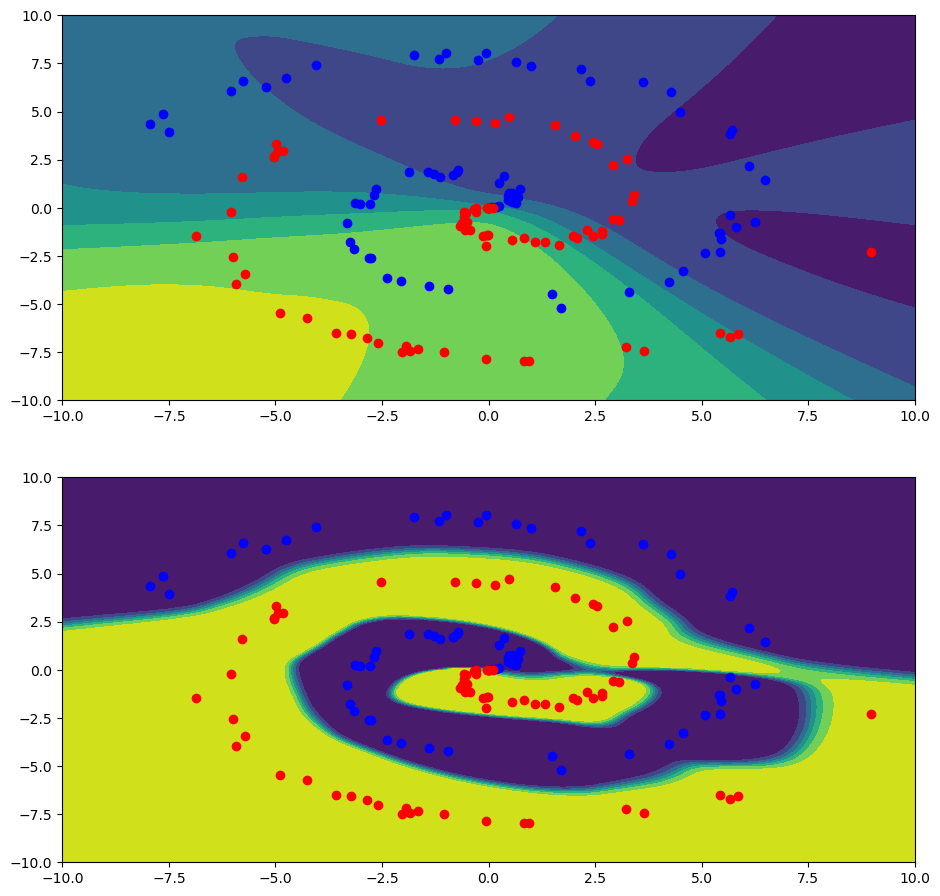

In [15]:
from FCNN import FCNN
from Datasets import Spiral

key, ds_key = random.split(key)
spiral = Spiral(75, ds_key)
dataset = spiral.get_dataset()

network = FCNN(num_neurons_per_layer=[10, 10, 10, 10, 10, 2])
key, init_x_key = random.split(key)
x_init = random.uniform(init_x_key, (2,))
key, init_key = random.split(key)
params = network.init(init_key, x_init)

#print(jax.tree_map(lambda x: x.shape, params))
fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))
spiral.plot(ax1)
network.plot_decision_boundary(params, ax1)
key, train_key = random.split(key)
params = network.train(train_key, params, dataset, 150)
spiral.plot(ax2)
network.plot_decision_boundary(params, ax2)